# Model Development

## Import necessary libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../") 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Data processing modules
import numpy as np

# Model development modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# Import custom modules
from src.utils.data_loader import load_processed_data
from src.utils.visualization import plot_correlation_matrix
from src.utils.fgra import grey_relational_analysis, normalize_data, fuzzyfication, rank_features, compute_grey_relational_coefficients, grey_relational_coefficient
from src.models.train import train_and_evaluate_models
from src.models.evaluate import evaluate_model
from src.models.optimize import optimize_model
from src.utils.model_persistence import save_model

2023-08-29 09:26:29.221460: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-29 09:26:29.223024: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-29 09:26:29.247937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-29 09:26:29.248974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 09:26:29.725126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# numeric_data = pd.read_csv('../var/story_encoded.csv')
numeric_data = pd.read_csv('../var/story_scaled.csv')
# numeric_data = load_processed_data()

## Feature Selection with Fuzzy GRA

### Fuzzification

In [3]:
normalized_data = normalize_data(numeric_data)
normalized_data.head()

,ID,Jira_ID,Status_0,Status_1,Status_2,Status_3,Status_4,Status_5,Status_6,Resolution_0,...,Has_Resolution_Date,Title_Length,Title_Unique_Words,Description_Length,Description_Unique_Words,Description_Text_Length,Description_Text_Unique_Words,Description_Code_Length,Description_Code_Unique_Words,Time_To_Estimate_Minutes
0,0.000000,0.005076,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.160448,0.204545,0.000091,0.002291,0.000092,0.002291,0.000023,0.000281,0.0
1,0.000002,0.005066,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.156716,0.136364,0.000734,0.006675,0.000261,0.004483,0.000973,0.004212,0.0
2,0.000004,0.005037,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.201493,0.181818,0.000391,0.006475,0.000395,0.006475,0.000023,0.000281,0.0
3,0.000006,0.004649,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.070896,0.068182,0.000042,0.000100,0.000043,0.000100,0.000023,0.000281,1.0
4,0.000008,0.004638,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.246269,0.204545,0.000830,0.011257,0.000839,0.011257,0.000023,0.000281,1.0


### Calculate Grey Relational Coefficient

In [4]:
reference_sequence = normalized_data['Story_Point'].mean()
coefficients = normalized_data.apply(lambda x: grey_relational_coefficient(x, reference_sequence))
# Drop the target column as we don't need its relational coefficient with itself
coefficients = coefficients.drop(columns=['Story_Point'])
# normalized_data['story_similarity'] = coefficients

In [5]:
# Calculate the absolute difference between each feature and the target (Story_Point)
deltas = abs(normalized_data.drop(columns='Story_Point') - normalized_data['Story_Point'].values.reshape(-1, 1))

# Calculate delta_min and delta_max
delta_min = deltas.min().min()
delta_max = deltas.max().max()

# Calculate Grey Relational Coefficients (GRC) using the formula
rho = 0.5
GRC = (delta_min + rho * delta_max) / (deltas + rho * delta_max)

GRC.head()

,ID,Jira_ID,Status_0,Status_1,Status_2,Status_3,Status_4,Status_5,Status_6,Resolution_0,...,Has_Resolution_Date,Title_Length,Title_Unique_Words,Description_Length,Description_Unique_Words,Description_Text_Length,Description_Text_Unique_Words,Description_Code_Length,Description_Code_Unique_Words,Time_To_Estimate_Minutes
0,1.000000,0.989951,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,1.000000,...,1.000000,0.757062,0.709677,0.999818,0.995438,0.999817,0.995438,0.999954,0.999439,1.000000
1,0.999996,0.989970,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,1.000000,...,1.000000,0.761364,0.785714,0.998535,0.986827,0.999479,0.991114,0.998057,0.991646,1.000000
2,0.999993,0.990026,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.333333,0.999999,...,0.999999,0.712766,0.733334,0.999219,0.987216,0.999212,0.987216,0.999955,0.999439,0.999999
3,0.999989,0.990789,0.999999,0.999999,0.999999,0.999999,0.999999,0.333333,0.999999,0.999999,...,0.333333,0.875817,0.880000,0.999916,0.999801,0.999915,0.999801,0.999955,0.999439,0.333333
4,0.999985,0.990810,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,1.000000,...,1.000000,0.670000,0.709678,0.998343,0.977982,0.998325,0.977982,0.999954,0.999439,0.333333


In [6]:
# Calculate Grey Relational Grade (GRG) for each feature
GRG = GRC.mean()

# Sorting the features based on GRG
GRG_sorted = GRG.sort_values(ascending=False)

GRG_sorted

Status_0                                0.999198
Description_Text_Length                 0.999133
Description_Code_Length                 0.998986
Description_Length                      0.998700
In_Progress_Minutes                     0.998173
Description_Code_Unique_Words           0.997525
Total_Effort_Minutes                    0.992223
Description_Text_Unique_Words           0.990021
Description_Unique_Words                0.988783
Story_Point_Changed_After_Estimation    0.986619
Status_1                                0.985303
Status_3                                0.973099
Resolution_1                            0.956603
Sprint_ID                               0.955917
Jira_ID                                 0.939548
Resolution_Time_Minutes                 0.938357
Status_2                                0.936940
Resolution_0                            0.928119
Title_Changed_After_Estimation          0.905778
Resolution_3                            0.886573
Status_6            

### Compute Grey Relational Grade

### Feature Ranking

In [7]:
# Rank the Features based on average coefficient
ranked_features = coefficients.mean().sort_values(ascending=False)

print(ranked_features)

Status_0                                0.999200
Description_Text_Length                 0.999139
Description_Code_Length                 0.998994
Description_Length                      0.998706
In_Progress_Minutes                     0.998171
Description_Code_Unique_Words           0.997535
Total_Effort_Minutes                    0.992223
Description_Text_Unique_Words           0.990031
Description_Unique_Words                0.988793
Story_Point_Changed_After_Estimation    0.986621
Status_1                                0.985304
Status_3                                0.973101
Resolution_1                            0.956604
Sprint_ID                               0.955919
Jira_ID                                 0.939553
Resolution_Time_Minutes                 0.938359
Status_2                                0.936942
Resolution_0                            0.928121
Title_Changed_After_Estimation          0.905780
Resolution_3                            0.886572
Status_6            

In [8]:
ranked_features = grey_relational_analysis(numeric_data, target_col='Story_Point')
print(ranked_features)

Status_0                                0.999198
Description_Text_Length                 0.999133
Description_Code_Length                 0.998986
Description_Length                      0.998700
In_Progress_Minutes                     0.998173
Description_Code_Unique_Words           0.997525
Total_Effort_Minutes                    0.992223
Description_Text_Unique_Words           0.990021
Description_Unique_Words                0.988783
Story_Point_Changed_After_Estimation    0.986619
Status_1                                0.985303
Status_3                                0.973099
Resolution_1                            0.956603
Sprint_ID                               0.955917
Jira_ID                                 0.939548
Resolution_Time_Minutes                 0.938357
Status_2                                0.936940
Resolution_0                            0.928119
Title_Changed_After_Estimation          0.905778
Resolution_3                            0.886573
Status_6            

### Visualise the feature importance

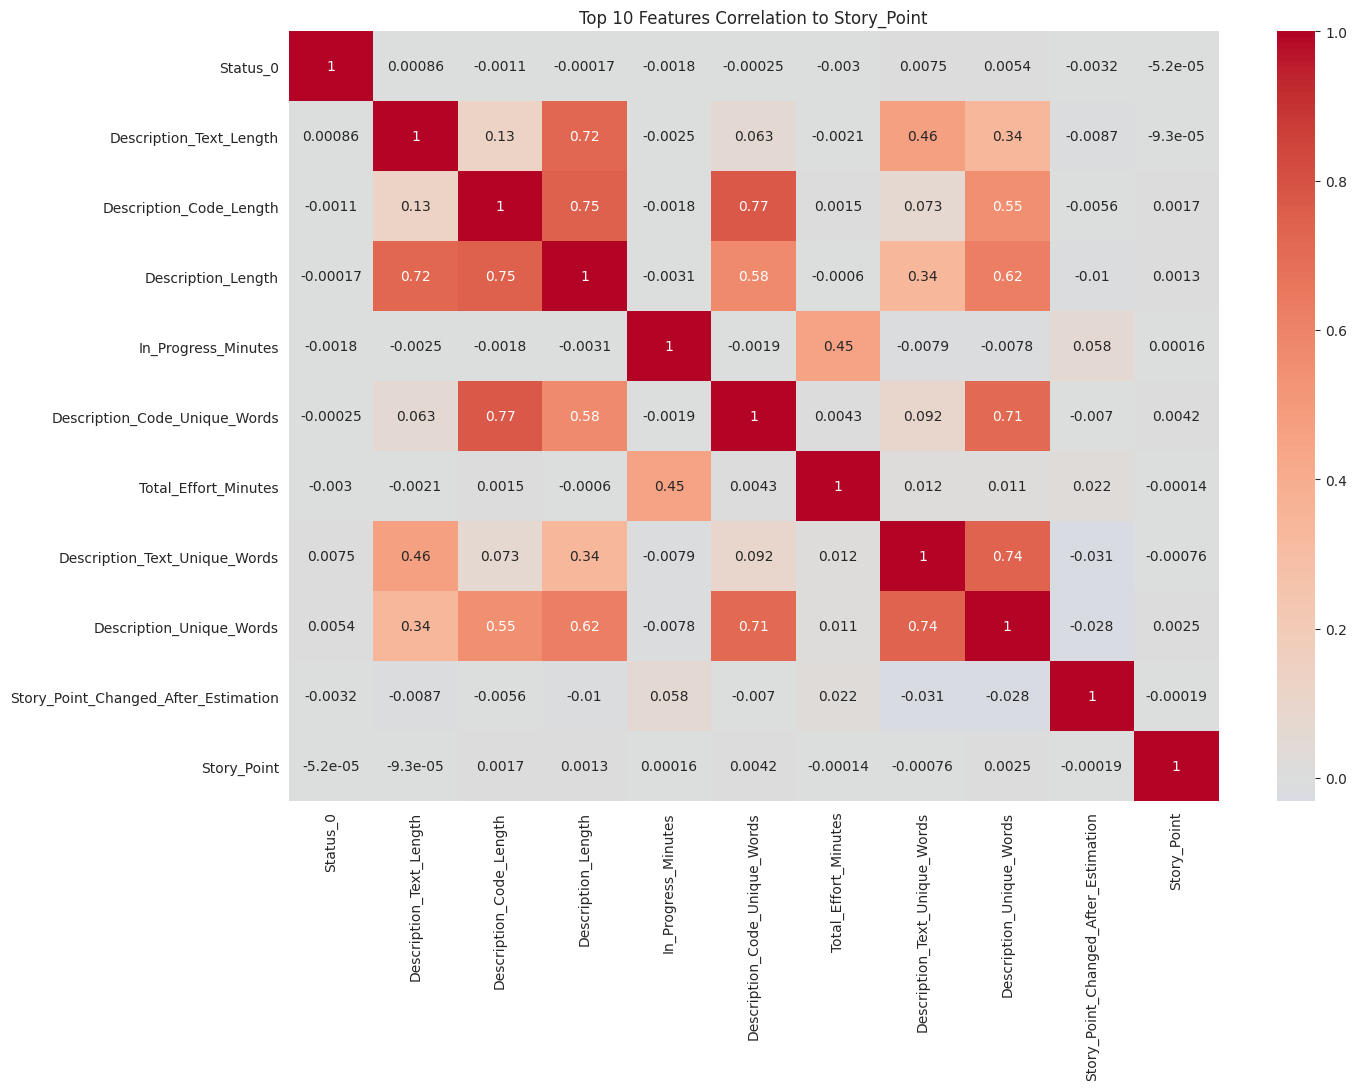

In [9]:
top_features_with_highest_ranking_with_sp = ranked_features.index[:10]

# Create a smaller correlation matrix with only the top features including 'Story_Point'
fgra_correlation_matrix = numeric_data[top_features_with_highest_ranking_with_sp].join(numeric_data['Story_Point']).corr()
plot_correlation_matrix(fgra_correlation_matrix, 'Top 10 Features Correlation to Story_Point')

# Model Development

## Data Splitting

In [10]:
# Features and target variable
X = numeric_data.drop(columns=['Story_Point'])
# X = numeric_data[top_correlations.index]
y = numeric_data['Story_Point']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train Models without FGRA Features

Linear Regression (Baseline Model) Metrics:
MSE: 7784544116.194064
RMSE: 88230.06356222386
MAE: 292.33526477414136
R2: -1.099266507242902e-05


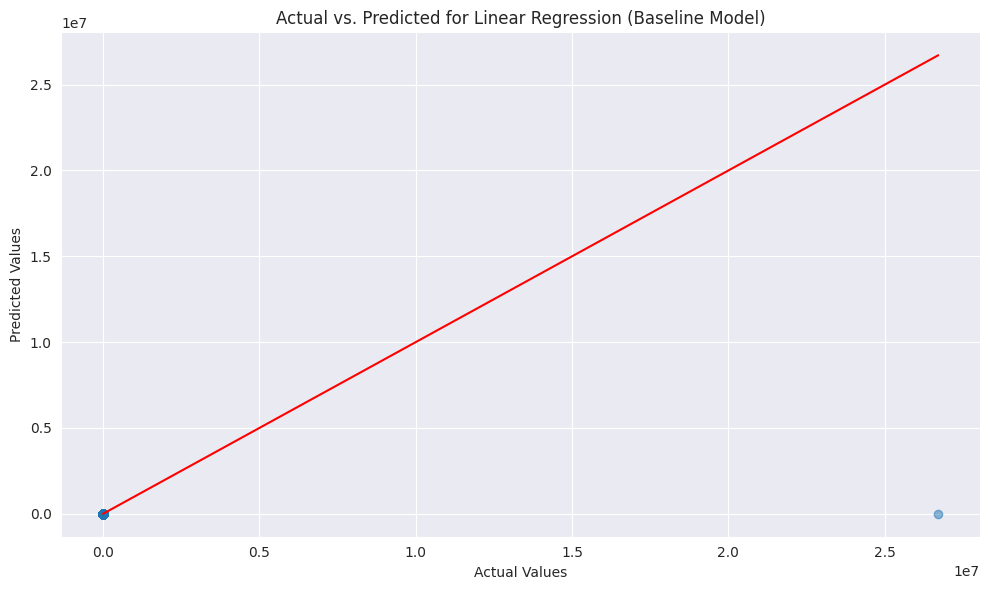

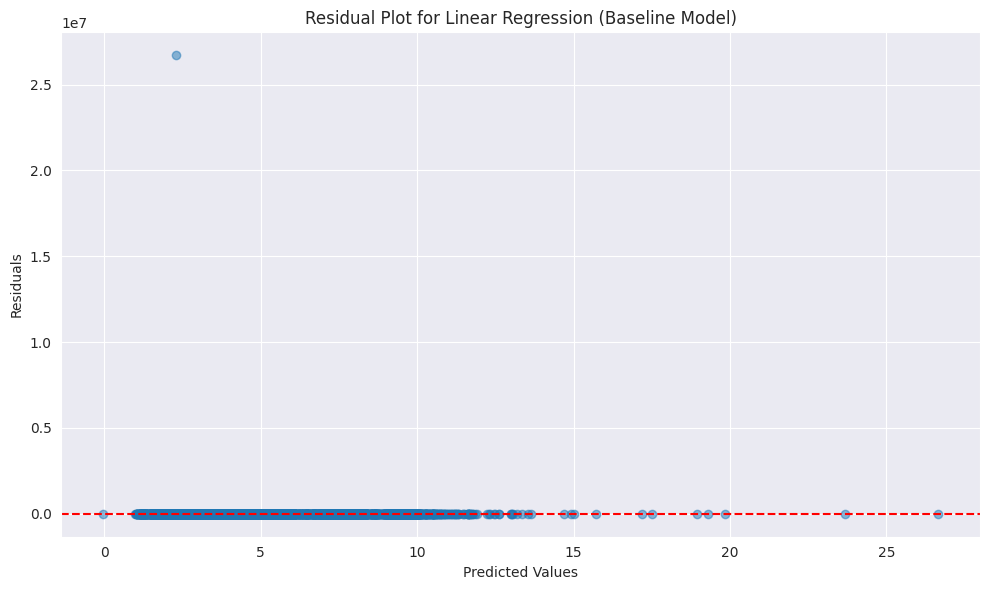

In [ ]:
%%time
models_without_fgra = [
    ('Linear Regression (Baseline Model)', LinearRegression()),
    ('Random Forest Regression', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('Gradient Boosting Regression', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    # ('Artificial Neural Networks (ANN)', None),
]
trained_models_without_fgra = train_and_evaluate_models(models_without_fgra, X_train, y_train, X_test, y_test)

## Train Models with FGRA Features

In [ ]:
# selected_features = ranked_features.index[:25]  # selecting top 10 features
selected_features = GRG_sorted.index[:25]
X_selected = numeric_data[selected_features]
y_selected = numeric_data['Story_Point']

# Splitting the data with selected features
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)

In [ ]:
%%time
models_with_fgra = [
    ('Random Forest (with FGRA Features)', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('Gradient Boosting (with FGRA Features)', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('Artificial Neural Networks (with FGRA Features)', None),
]
predictions_with_fgra = train_and_evaluate_models(models_with_fgra, X_train_selected, y_train_selected, X_test_selected, y_test_selected)

# Model Optimization

## Optimized the best model

In [ ]:
# optimize_model(model)

# Model Persistence

In [ ]:
# Save model
# save_model(model, '../artifacts/models/optimized_model.joblib')